In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import roc_curve, auc
from rdkit import Chem
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

matplotlib.rcdefaults()
sns.set_style("darkgrid")
plt.rcParams["figure.dpi"] = 100

pd.set_option("display.max_columns", None)

In [2]:
# title suffix
title_suffix = "GPR40"

# Files we are processing
file_path_sdf_active = "./GPR40/docking/GPR40_active_docking_lib_sorted.sdf"
file_path_sdf_decoy = "./GPR40/docking/GPR40_decoy_docking_lib_sorted.sdf"
file_path_strain_active = "./GPR40/strain/GPR40_active_docking_lib_sorted.csv"
file_path_strain_decoy = "./GPR40/strain/GPR40_decoy_docking_lib_sorted.csv"

In [3]:
# Parameters
title_suffix = "P2Y12"
file_path_sdf_active = "./P2Y12/docking/P2Y12_active_docking_lib_sorted.sdf"
file_path_sdf_decoy = "./P2Y12/docking/P2Y12_decoy_docking_lib_sorted.sdf"
file_path_strain_active = "./P2Y12/strain/P2Y12_active_docking_lib_sorted.csv"
file_path_strain_decoy = "./P2Y12/strain/P2Y12_decoy_docking_lib_sorted.csv"


In [4]:
# import matplotx

# plt.style.use(matplotx.styles.tokyo_night["storm"])

In [5]:
def sdf_to_df(args):
    """
    Load molecules and their properties from an SDF file into a DataFrame.

    Example usage: df=sdf_to_df(("./ADRB1/docking/ADRB1_active_docking_lib.sdf", "active"))

    Note that this function was originally intended to be used with the `multiprocessing` module, so the arguments are passed as a tuple.

    Will likely be updated later.

    """
    file, active_status = args  # Unpack the tuple of arguments

    # Create a molecule supplier
    mol_supplier = Chem.MultithreadedSDMolSupplier(file, numWriterThreads=8)

    # Load the molecules and their properties into a list
    molecules = []
    first_mol = True
    for mol in mol_supplier:
        if mol is not None:
            if first_mol:
                # Get properties as dictionary only for the first molecule
                props = mol.GetPropsAsDict()
                keys = props.keys()
                first_mol = False
            else:
                # For the rest of the molecules, get properties directly
                props = {key: mol.GetProp(key) for key in keys if mol.HasProp(key)}

            props["Title"] = mol.GetProp("_Name")
            props["Mol"] = mol
            props["Activity"] = 1 if active_status == "active" else 0
            molecules.append(props)

    # Convert the list into a DataFrame
    df = pd.DataFrame(molecules)

    # Reorder the DataFrame columns
    cols = ["Title", "Mol", "Activity"] + [
        col for col in df.columns if col not in ["Title", "Mol", "Activity"]
    ]
    df = df[cols]
    df = df.rename(columns={"Title": "Molecule_Name"})

    # Convert 'r_i_docking_score' to numeric, coercing errors to NaN
    df["r_i_docking_score"] = pd.to_numeric(df["r_i_docking_score"], errors="coerce")

    # Print 'Molecule_Name' and 'r_i_docking_score' for entries that could not be converted
    non_convertible_entries = df[df["r_i_docking_score"].isna()]
    for _, row in non_convertible_entries.iterrows():
        print(
            f"Molecule_Name: {row['Molecule_Name']}, r_i_docking_score: {row['r_i_docking_score']}"
        )

    # Drop rows with non-convertible 'r_i_docking_score'
    df = df.dropna(subset=["r_i_docking_score"])

    # Convert 'r_i_docking_score' to int64
    df["r_i_docking_score"] = df["r_i_docking_score"].astype("float64")

    return df

In [6]:
active_sdf = sdf_to_df((file_path_sdf_active, "active"))
decoy_sdf = sdf_to_df((file_path_sdf_decoy, "inactive"))

In [7]:
#TODO replace with a check for duplicates and sys exit with message
duplicates_actives = active_sdf["Molecule_Name"].duplicated()
print(any(duplicates_actives))
duplicates_decoys = decoy_sdf["Molecule_Name"].duplicated()
print(any(duplicates_decoys))

False
False


In [8]:
# from old code, probably fine but not optimal
def concatenate_csv_files(file_list):
    """
    Concatenates multiple strain CSV files into a single dataframe.
    Only the first five columns are kept for now.

    Args:
        file_list (list): A list of file paths to the CSV files.

    Returns:
        pandas.DataFrame: The concatenated dataframe.

    """
    # Specify the column names
    column_names = [
        "Molecule_Name",
        "Total_E",
        "Lower_Bound",
        "Upper_Bound",
        "Num_Torsion_Patterns",
    ]

    # List to hold dataframes
    df_list = []

    # Loop over each file in the list
    for file in file_list:
        # Import the CSV file as a df, using only the first five columns of the CSV file
        df = pd.read_csv(file, usecols=range(5), names=column_names, header=0)
        df_list.append(df)

    # Concatenate all dataframes in the list
    final_df = pd.concat(df_list, ignore_index=True)

    return final_df

In [9]:
active_strain = concatenate_csv_files([file_path_strain_active])
decoy_strain = concatenate_csv_files([file_path_strain_decoy])

In [10]:
#TODO replace with a check for duplicates and sys exit with message
duplicates_actives = active_strain["Molecule_Name"].duplicated()
print(any(duplicates_actives))
duplicates_decoys = decoy_strain["Molecule_Name"].duplicated()
print(any(duplicates_decoys))

False
False


In [11]:
# only keep as commented for debug
# pre_merge = [active_sdf, decoy_sdf, active_strain, decoy_strain]

# for df in pre_merge:
#     print(df.shape)

In [12]:
active_data=pd.merge(active_sdf, active_strain, on='Molecule_Name')
decoy_data=pd.merge(decoy_sdf, decoy_strain, on='Molecule_Name')

In [13]:
# #only keep as commented for debug
# post_merge = [active_data, decoy_data]

# for df in post_merge:
#     print(df.shape)

In [14]:
all_data = pd.concat([active_data, decoy_data])

#print(all_data.shape)

In [15]:
def plot_density(df, title_suffix):
  # Hardcoded column names
  activity_col = 'Activity'
  score_col = 'r_i_docking_score'

  # Create a density plot for the score of active and inactive molecules
  sns.kdeplot(df.loc[df[activity_col] == 0, score_col], label='Inactive', fill=True)
  sns.kdeplot(df.loc[df[activity_col] == 1, score_col], label='Active', fill=True)

  # Add title and labels
  plt.title(f'Density Plot of Docking Score for Active and Decoy Molecules ({title_suffix})')
  plt.xlabel('Docking Score')
  plt.ylabel('Density')
  plt.legend(loc='best')

  # Show the plot
  plt.show()

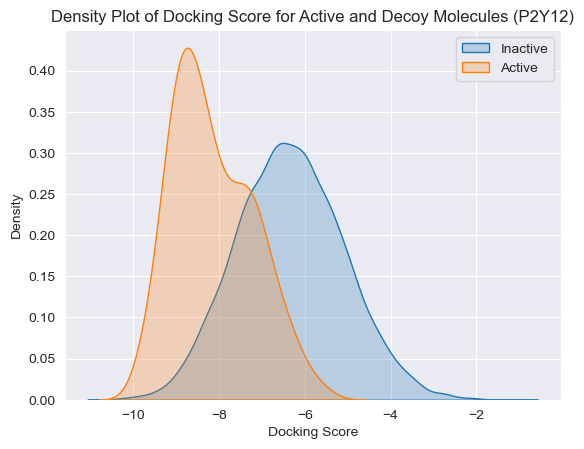

In [16]:
plot_density(all_data, title_suffix)

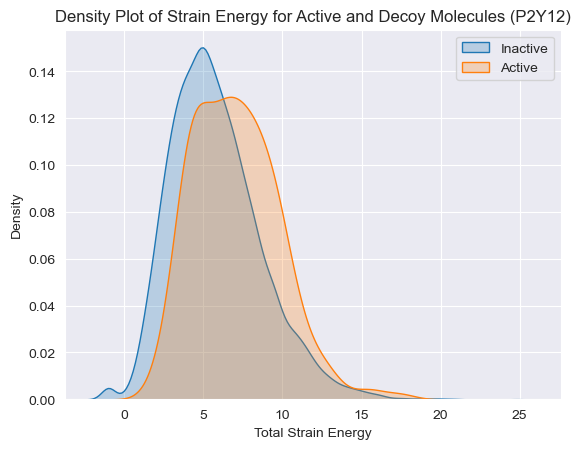

In [17]:
def plot_density_strain(df, title_suffix):
    # Hardcoded column names
    activity_col = "Activity"
    score_col = "Total_E"

    # Create a density plot for the score of active and inactive molecules
    sns.kdeplot(df.loc[df[activity_col] == 0, score_col], label="Inactive", fill=True)
    sns.kdeplot(df.loc[df[activity_col] == 1, score_col], label="Active", fill=True)

    # Add title and labels
    plt.title(
        f"Density Plot of Strain Energy for Active and Decoy Molecules ({title_suffix})"
    )
    plt.xlabel("Total Strain Energy")
    plt.ylabel("Density")
    plt.legend(loc="best")

    # Show the plot
    plt.show()

plot_density_strain(all_data, title_suffix)

In [18]:
def calculate_enrichment_parameters(df):
    """
    Calculates parameters we will need for Enrichment Plots

    Parameters:
    df (pandas.DataFrame): The dataframe to calculate the logAUC for.

    Returns:
    pandas.DataFrame: The dataframe with the logAUC calculated.
    """
    # Sort the subset by 'r_i_docking_score' in ascending order

    df = df.copy()

    df.sort_values(by="r_i_docking_score", inplace=True)

    # Reset the index so that we are ranking by the docking score
    df.reset_index(drop=True, inplace=True)

    # Adjusting the index to start from 1
    df.index += 1

    # Calculate the cumulative sum of active compounds
    df["Cumulative_Actives"] = df["Activity"].cumsum()

    # Calculate the Total Actives
    df["Total_Actives"] = df["Activity"].sum()

    # Calculate the fraction of identified actives at each row
    df["Fraction_Actives"] = df["Cumulative_Actives"] / df["Total_Actives"]

    # Calculate the percentage of compounds screened at each row
    df["Percentage_Screened"] = df.index / len(df)

    return df

In [19]:
all_data = calculate_enrichment_parameters(all_data)
all_data

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened
1,C39794003_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x15ec16ea0>,0,P2Y12_chembl19_set_decoy_sc.smi,6297,53161,0,S-OPLS,38.0159,1,C39794003_Isomer1-1,P2Y12,6295,8,-10.48680,-0.34956,-1.08616,-2.38272,-10.4868,-3.40285,-0.666682,-0,-2.88739,-53.892,-8.25561,0.423472,-0.0204131,-95.4206,-62.1476,5.12474,16,292,0,12.098180,9.878964,NaN,4.0,0,205,0.0,0.000087
2,C20906690_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x15ec16f80>,0,P2Y12_chembl19_set_decoy_sc.smi,6679,53161,0,S-OPLS,27.7373,1,C20906690_Isomer1-1,P2Y12,6677,10,-10.38470,-0.33499,-1.05233,-2.34206,-10.3847,-3.3933,-1.19354,-0,-1.5536,-43.2751,-17.6723,0.826727,-0.25638,-100.397,-60.9474,8.29938,60,194,0,10.987322,8.922633,NaN,5.0,0,205,0.0,0.000175
3,C38557373_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x15ec170d0>,0,P2Y12_chembl19_set_decoy_sc.smi,6993,53161,0,S-OPLS,34.9006,1,C38557373_Isomer1-1,P2Y12,6991,7,-10.33250,-0.303896,-0.984504,-2.28273,-10.3325,-4.90048,-0.628864,-0,-1.10106,-55.7647,-9.00672,0.476542,-0.0393534,-103.764,-64.7714,13.5705,15,293,0,12.084084,9.100534,NaN,6.0,0,205,0.0,0.000262
4,C20905467_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x15ec17140>,0,P2Y12_chembl19_set_decoy_sc.smi,8736,53161,0,S-OPLS,48.3486,1,C20905467_Isomer1-1,P2Y12,8734,9,-10.25760,-0.301696,-0.977377,-2.2662,-10.2576,-4.52063,-0.460814,-0,-1.08475,-47.6146,-14.4891,0.631486,-0.268836,-94.5051,-62.1037,23.5367,178,329,0,13.990778,11.719505,NaN,7.0,0,205,0.0,0.000350
5,C40435144_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x15ec171b0>,0,P2Y12_chembl19_set_decoy_sc.smi,10756,53161,0,S-OPLS,52.7382,1,C40435144_Isomer1-1,P2Y12,10754,6,-10.22860,-0.292247,-0.95596,-2.24542,-10.2286,-4.64221,-0.517898,-0,-1.52622,-56.7634,-7.81131,0.509474,-0.0419297,-101.348,-64.5747,11.4477,36,386,0,7.945418,6.210284,NaN,1.0,0,205,0.0,0.000437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11428,C79088218_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a9f4c900>,0,P2Y12_chembl19_set_decoy_sc.smi,9657,53161,0,S-OPLS,30.9075,1,C79088218_Isomer1-1,P2Y12,9655,8,-2.03127,-0.112848,-0.295746,-0.522127,-2.03127,-1.79542,-0.258147,-0,-1.68177,-25.1075,-5.68271,3.83174,-0.0198852,-33.3216,-30.7902,3.34626,36,393,0,6.155626,5.726850,6.680163,5.0,205,205,1.0,0.999650
11429,C76052766_Isomer2,<rdkit.Chem.rdchem.Mol object at 0x2a9f4c9e0>,0,P2Y12_chembl19_set_decoy_sc.smi,9910,53161,0,S-OPLS,36.4643,1,C76052766_Isomer2-1,P2Y12,9908,8,-1.99945,-0.0869328,-0.247225,-0.483486,-1.99945,-1.51586,-0.0650726,-0,-1.12816,-1.30987,1.16763,0.630143,-0.0301611,-7.7241,-0.142238,7.72412,46,336,0,10.947914,8.354256,NaN,6.0,205,205,1.0,0.999738
11430,C43743480_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a9f4cb30>,0,P2Y12_chembl19_set_decoy_sc.smi,5935,53161,0,S-OPLS,73.0092,1,C43743480_Isomer1-1,P2Y12,5933,10,-1.83346,-0.0509293,-0.168165,-0.40001,-1.83346,-0.154871,-0.237666,-0,0,-19.3289,-6.48994,0.568255,-0.0692399,-29.4268,-25.8188,3.80384,175,309,0,7.365707,6.169484,NaN,5.0,205,205,1.0,0.999825
11431,C79630235_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a9f4ca50>,0,P2Y12_chembl19_set_decoy_sc.smi,9228,53161,0,S-OPLS,39.5067,1,C79630235_Isomer1-1,P2Y12,9226,7,-1.69653,-0.065251,-0.193306,-0.398423,-1.69

In [20]:
total_e_thresholds = [None, 4, 4.5, 5.0, 5.5, 6.0, 7.0, 7.5, 8.0]

In [21]:
def logauc_by_strain(df, a=1e-3, total_e_threshold=None):
    # Filter dataframe based on 'Total_E' threshold if provided
    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    # Invert scores since lower scores indicate positive class
    y_scores_inverted = -df["r_i_docking_score"]

    # Calculate FPR, TPR, and thresholds using sklearn
    fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

    # Select the thresholds that result in FPR >= a for log scale plotting
    valid_indices = np.where(fpr >= a)
    fpr_valid = fpr[valid_indices]
    tpr_valid = tpr[valid_indices]

    # Calculate log of FPR for valid indices
    log_fpr_valid = np.log10(fpr_valid)

    # Calculate the AUC for the valid range
    linlog_auc = auc(log_fpr_valid, tpr_valid)

    ### NOTE TIMES 10 NOTE ###
    log_auc = (linlog_auc / -np.log10(a)) * 10

    return log_auc

In [22]:
def plot_log_aucs(data, thresholds, title_suffix):
    # Calculate log_auc for each threshold and plot
    log_aucs = [logauc_by_strain(data, total_e_threshold=t) for t in thresholds]
    
    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]
    
    plt.bar(range(len(thresholds)), log_aucs, tick_label=x_labels)
    plt.title(f"Linear Log10 AUC by Strain Energy Cutoff ({title_suffix})")
    plt.xlabel("Strain Energy Cutoff")
    plt.ylabel("Linear Log10 AUC (x10)")
    plt.show()

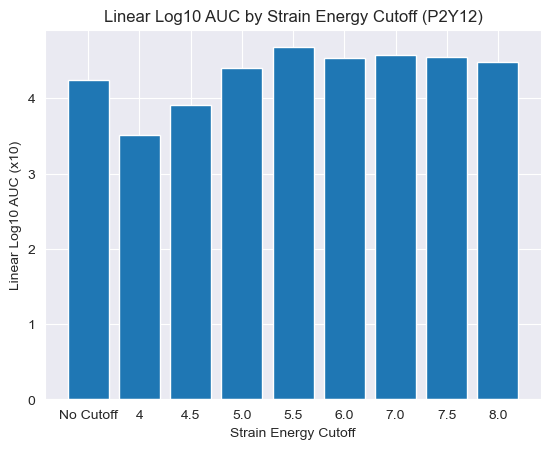

In [23]:
plot_log_aucs(all_data, total_e_thresholds, title_suffix)

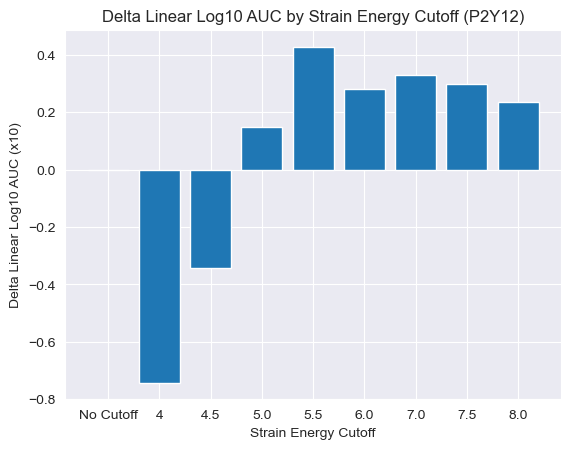

In [24]:
def plot_delta_log_aucs(data, thresholds, title_suffix):
  # Calculate log_auc for 'None' threshold
  none_log_auc = logauc_by_strain(data, total_e_threshold=None)
  
  # Calculate delta log_auc for each threshold and plot
  delta_log_aucs = [logauc_by_strain(data, total_e_threshold=t) - none_log_auc for t in thresholds]
  
  # Create labels for the x-axis
  x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]
  
  plt.bar(range(len(thresholds)), delta_log_aucs, tick_label=x_labels)
  plt.title(f"Delta Linear Log10 AUC by Strain Energy Cutoff ({title_suffix})")
  plt.xlabel("Strain Energy Cutoff")
  plt.ylabel("Delta Linear Log10 AUC (x10)")
  plt.show()

plot_delta_log_aucs(all_data, total_e_thresholds, title_suffix)

In [25]:
def write_log_aucs(data, thresholds, title_suffix):
    # Calculate log_auc for each threshold
    log_aucs = [logauc_by_strain(data, total_e_threshold=t) for t in thresholds]

    delta_log_aucs = [0] + [log_aucs[i] - log_aucs[0] for i in range(1, len(log_aucs))]

    # print(f"Delta LogAUCs for {title_suffix}: {delta_log_aucs}")

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]

    # Create a dataframe to hold the data
    df = pd.DataFrame({
        "Protein": title_suffix,
        "Strain Energy Cutoff": x_labels,
        "Linear Log10 AUC (x10)": log_aucs,
        "Delta Linear Log10 AUC (x10)": delta_log_aucs
    })

    # Write the dataframe to a CSV file
    df.to_csv(f"./papermill/csv/strain_log_aucs_{title_suffix}.csv", index=False)

write_log_aucs(all_data, total_e_thresholds, title_suffix)

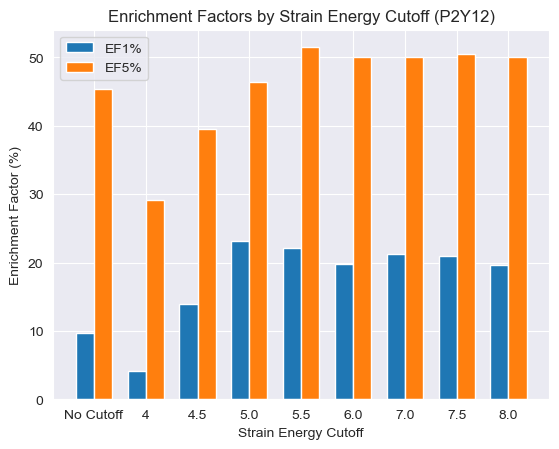

In [26]:
def enrichment_metrics_by_strain(df, total_e_threshold=None):

    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    df = calculate_enrichment_parameters(df).copy()

    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]

    ef1 = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
    ) * 100

    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    ef5 = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]) * 100

    # print(df.shape)

    # print(
    #     f"1% Closest Cumulative_Actives: {closest_to_one_percent['Cumulative_Actives'].values[0]}"
    # )
    # print(
    #     f"1% Closest Total_Actives: {closest_to_one_percent['Total_Actives'].values[0]}"
    # )
    # print(
    #     f"5% Closest Cumulative_Actives: {closest_to_five_percent['Cumulative_Actives'].values[0]}"
    # )
    # print(
    #     f"5% Closest Total_Actives: {closest_to_five_percent['Total_Actives'].values[0]}"
    # )

    return ef1, ef5


def bar_plot_enrichment_by_strain(data, thresholds, title_suffix):
    # Calculate enrichment for each threshold
    ef1s, ef5s = zip(*[enrichment_metrics_by_strain(data, total_e_threshold=t) for t in thresholds])

    # print(f"EF1% for {title_suffix}: {ef1s}")
    # print(f"EF5% for {title_suffix}: {ef5s}")

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]

    # Create an array with the positions of each bar on the x axis
    x = np.arange(len(x_labels))

    # Set the width of the bars
    bar_width = 0.35

    plt.bar(x - bar_width/2, ef1s, bar_width, label="EF1%")
    plt.bar(x + bar_width/2, ef5s, bar_width, label="EF5%")
    plt.title(f"Enrichment Factors by Strain Energy Cutoff ({title_suffix})")
    plt.xlabel("Strain Energy Cutoff")
    plt.ylabel("Enrichment Factor (%)")
    plt.xticks(x, x_labels)  # Set the position and labels of the xticks
    plt.legend()
    plt.show()

bar_plot_enrichment_by_strain(all_data, total_e_thresholds, title_suffix)

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_73901/2506411786.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(


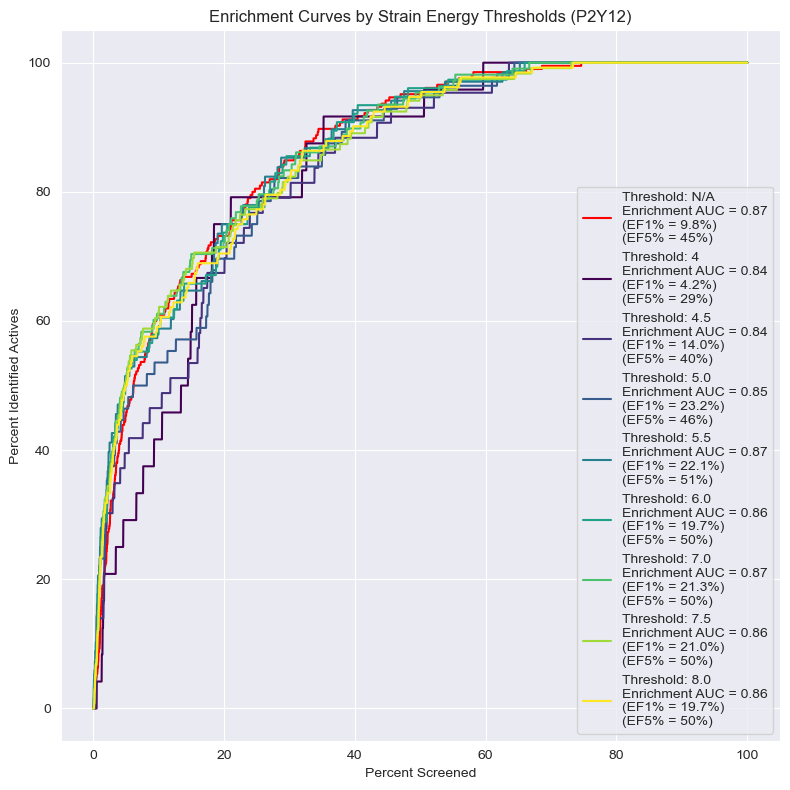

In [27]:
def plot_enrichment_curve_by_strain(df, total_e_threshold=None, ax=None, color='blue'):

    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    df = calculate_enrichment_parameters(df).copy()

    enrichment_auc = auc(df["Percentage_Screened"], df["Fraction_Actives"])

    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]

    ef1 = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
    ) * 100

    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    ef5 = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]
    ) * 100

    # Plot the enrichment curve
    ax.plot(
        df["Percentage_Screened"] * 100,
        df["Fraction_Actives"] * 100,
        label="Threshold: {}\nEnrichment AUC = {:.2f}\n(EF1% = {:.1f}%)\n(EF5% = {:.0f}%)".format(
            total_e_threshold if total_e_threshold is not None else 'N/A',
            enrichment_auc, ef1, ef5
            ),
        color=color
        )

    # # Add axis labels and title
    # plt.xlabel("Compounds Screened (%)")
    # plt.ylabel("Percent of Identified Actives (%)")
    # plt.title(f"Enrichment Curve ({title_suffix})")

    ax.legend()


def plot_enrichment_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(
        figsize=(8, 8)
        )

    # Define a colormap
    cmap = cm.get_cmap(
        "viridis", len(thresholds) - 1
    )  # Subtract 1 because the first color is manually set

    # Plot semi-log ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Filter dataframe based on 'Total_E' threshold
        df_filtered = data if t is None else data[data["Total_E"] <= t]

        # Set a distinct color for the first threshold
        color = (
            "red" if t is None else cmap(i - 1)
        )  # Subtract 1 because the first color is manually set

        # Call the function with the filtered data
        plot_enrichment_curve_by_strain(df_filtered, total_e_threshold=t, ax=ax, color=color)

    ax.set_title(f"Enrichment Curves by Strain Energy Thresholds ({title_suffix})")
    ax.set_xlabel("Percent Screened")
    ax.set_ylabel("Percent Identified Actives")

    plt.tight_layout()
    plt.show()

plot = plot_enrichment_all_thresholds(all_data, total_e_thresholds, title_suffix)

In [28]:
def write_enrichment_metrics(data, thresholds, title_suffix):
    # Calculate enrichment for each threshold
    ef1s, ef5s = zip(*[enrichment_metrics_by_strain(data, total_e_threshold=t) for t in thresholds])

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]

    # Create a dataframe to hold the data
    df = pd.DataFrame({
        "Protein": title_suffix,
        "Strain Energy Cutoff": x_labels,
        "EF1%": ef1s,
        "EF5%": ef5s
    })

    print(f"Writing CSV to strain_enrichment_metrics_{title_suffix}.csv")
    df.to_csv(f"./papermill/csv/strain_enrichment_metrics_{title_suffix}.csv", index=False)
    print("CSV writing complete.")

    try:
        df.to_csv(
            f"./papermill/csv/strain_enrichment_metrics_{title_suffix}.csv", index=False
        )
        print("CSV writing complete.")
    except Exception as e:
        print(f"Failed to write CSV: {e}")

write_enrichment_metrics(all_data, total_e_thresholds, title_suffix)

Writing CSV to strain_enrichment_metrics_P2Y12.csv
CSV writing complete.
CSV writing complete.


In [29]:
def plot_semi_log_roc(df, a=1e-3, total_e_threshold=None, ax=None, color='blue'):
  # Filter dataframe based on 'Total_E' threshold if provided
  if total_e_threshold is not None:
    df = df[df["Total_E"] <= total_e_threshold]

  # Invert scores since lower scores indicate positive class
  y_scores_inverted = -df["r_i_docking_score"]

  # Calculate FPR, TPR, and thresholds using sklearn
  fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

  # Select the thresholds that result in FPR >= a for log scale plotting
  valid_indices = np.where(fpr >= a)
  fpr_valid = fpr[valid_indices]
  tpr_valid = tpr[valid_indices]

  # Calculate log of FPR for valid indices
  log_fpr_valid = np.log10(fpr_valid)

  # Calculate LogAUC
  log_auc = (auc(log_fpr_valid, tpr_valid) / -np.log10(a)) * 10

  # Count the number of rows with Activity = 1 and the total number of rows
  activity_1_count = df[df["Activity"] == 1].shape[0]
  total_count = df.shape[0]

  # Plot semi-log ROC curve
  ax.plot(
    log_fpr_valid,
    tpr_valid,
    label=f"Threshold: {total_e_threshold if total_e_threshold is not None else 'N/A'}, LogAUC: {log_auc:.2f}, Actives: {activity_1_count}, Total count: {total_count}",
    color=color
  )
  ax.legend()


In [30]:
def plot_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Define a colormap
    cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set

    # Plot semi-log ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Filter dataframe based on 'Total_E' threshold
        df_filtered = data if t is None else data[data["Total_E"] <= t]

        # Set a distinct color for the first threshold
        color = 'red' if t is None else cmap(i - 1)  # Subtract 1 because the first color is manually set

        # Call the function with the filtered data
        plot_semi_log_roc(df_filtered, total_e_threshold=t, ax=ax, color=color)

    ax.set_title(f"Strain Energy Thresholds ({title_suffix})")
    ax.set_xlabel("log(FPR)")
    ax.set_ylabel("TPR")

    plt.tight_layout()
    plt.show()

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_73901/2145919082.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set


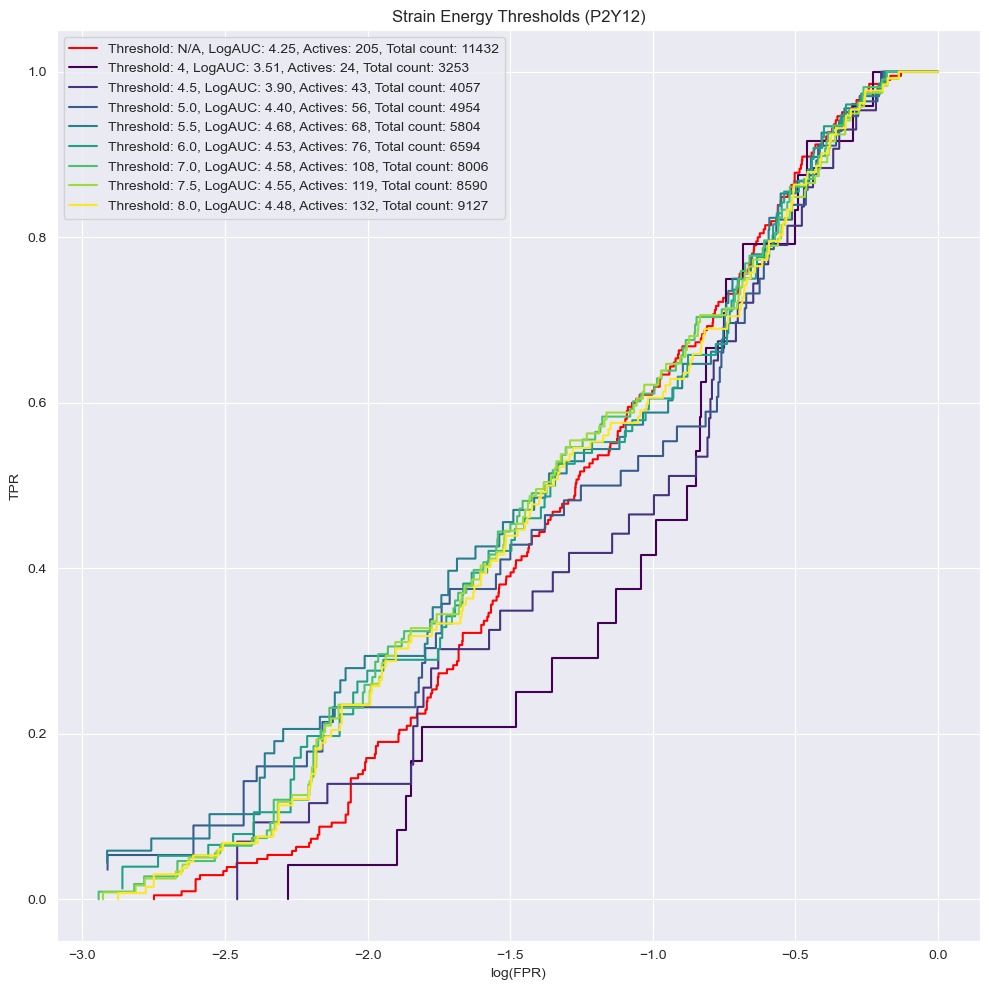

In [31]:
plot = plot_all_thresholds(all_data, total_e_thresholds, title_suffix)

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_73901/2191446731.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set


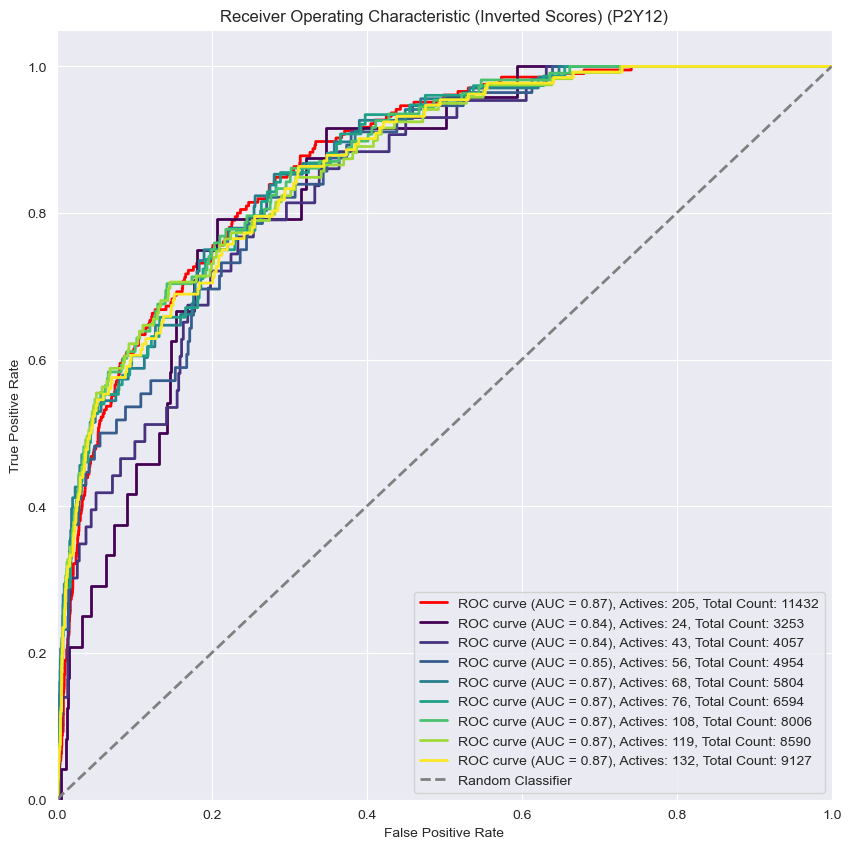

In [32]:
def plot_roc_curve_inverted(data, total_e_threshold, ax, title_suffix, color='blue'):
    """
    Plot the ROC curve for the given true labels and inverted scores.

    :param data: The DataFrame containing the data.
    :param total_e_threshold: The threshold for the 'Total_E' column. If this is not None, the data is filtered to only include rows where 'Total_E' is less than or equal to this threshold.
    :param ax: The axes object to plot on.
    :param title_suffix: The suffix to add to the title of the plot.
    :param color: The color to use for the ROC curve.
    """
    # Filter the data based on 'Total_E' threshold
    df = data if total_e_threshold is None else data[data["Total_E"] <= total_e_threshold]

    # Get the true labels and scores
    y_true = df["Activity"]
    y_scores = df["r_i_docking_score"]

    # Inverting the scores
    y_scores_inverted = -y_scores

    # Compute the ROC curve and AUC with inverted scores
    fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
    roc_auc = auc(fpr, tpr)

    # Count the number of rows with Activity = 1 and the total number of rows
    activity_1_count = df[df["Activity"] == 1].shape[0]
    total_count = df.shape[0]

    # Plotting the ROC curve
    ax.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.2f}), Actives: {activity_1_count}, Total Count: {total_count}", color=color)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"Receiver Operating Characteristic (Inverted Scores) ({title_suffix})")

def plot_roc_curves_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Define a colormap
    cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set

    # Plot ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Set a distinct color for the first threshold
        color = 'red' if t is None else cmap(i - 1)  # Subtract 1 because the first color is manually set

        plot_roc_curve_inverted(
            data,
            total_e_threshold=t,
            ax=ax,
            title_suffix=title_suffix,
            color=color
        )

    # Plot the random classifier line after all the ROC curves
    ax.plot([0, 1], [0, 1], lw=2, linestyle="--", label="Random Classifier", color="grey")

    ax.legend()

    plt.show()

plot_roc_curves_all_thresholds(all_data, total_e_thresholds, title_suffix)

In [33]:
def write_roc_metrics(data, thresholds, title_suffix):
    # Create a list to hold the data
    data_list = []

    # Loop over each threshold
    for t in thresholds:
        # Filter the data based on 'Total_E' threshold
        df = data if t is None else data[data["Total_E"] <= t]

        # Get the true labels and scores
        y_true = df["Activity"]
        y_scores = df["r_i_docking_score"]

        # Inverting the scores
        y_scores_inverted = -y_scores

        # Compute the ROC curve and AUC with inverted scores
        fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
        roc_auc = auc(fpr, tpr)

        # Count the number of rows with Activity = 1 and the total number of rows
        activity_1_count = df[df["Activity"] == 1].shape[0]
        total_count = df.shape[0]

        # Add the data to the list
        data_list.append({
            "Protein": title_suffix,
            "Strain Energy Cutoff": t if t is not None else 'No Cutoff',
            "ROC_AUC": roc_auc,
            "Actives": activity_1_count,
            "Total Count": total_count
        })

    # Create a dataframe from the list
    df = pd.DataFrame(data_list)

    # Write the dataframe to a CSV file
    df.to_csv(f"./papermill/csv/strain_roc_metrics_{title_suffix}.csv", index=False)

write_roc_metrics(all_data, total_e_thresholds, title_suffix)

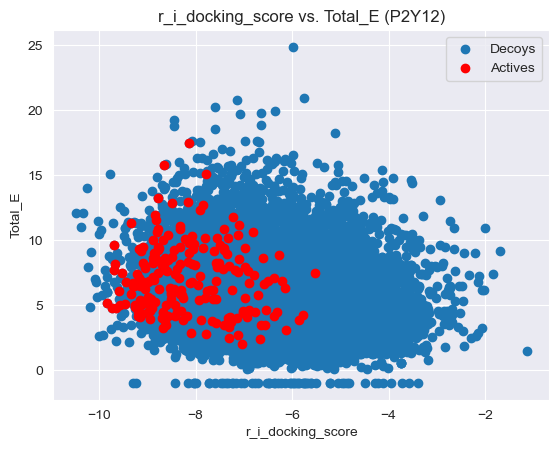

In [34]:
plt.scatter(all_data["r_i_docking_score"], all_data["Total_E"])
actives_all_data = all_data[all_data["Activity"] == 1]
plt.scatter(actives_all_data["r_i_docking_score"], actives_all_data["Total_E"], c="red")
plt.title(f"r_i_docking_score vs. Total_E ({title_suffix})")
plt.xlabel("r_i_docking_score")
plt.ylabel("Total_E")
plt.legend(["Decoys", "Actives"])
plt.show()

In [35]:
all_data_NegativeStrain=all_data[all_data["Total_E"] <= 0]
all_data_NegativeStrain

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened
81,C18179861_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x15ec58dd0>,0,P2Y12_chembl19_set_decoy_sc.smi,5955,53161,0,S-OPLS,31.3211,1,C18179861_Isomer1-1,P2Y12,5953,6,-9.30767,-0.320954,-0.986073,-2.13122,-9.30767,-4.55545,-0.127511,-0,-0.980022,-52.122,-10.4858,0.547889,-0.0136068,-102.532,-62.6078,4.70674,78,61,0,-1.0,0.0,0.0,1.0,13,205,0.063415,0.007085
96,C01150192_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x15ec59230>,0,P2Y12_chembl19_set_decoy_sc.smi,4536,53161,0,S-OPLS,32.4184,1,C01150192_Isomer1-1,P2Y12,4534,7,-9.24471,-0.318783,-0.979403,-2.1168,-9.24471,-2.91637,-0.537654,-0,-2.63202,-58.2286,-5.20391,0.533352,0,-95.9647,-63.4326,7.70175,67,65,0,-1.0,0.0,0.0,2.0,18,205,0.087805,0.008397
578,C52993071_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x15f69c580>,0,P2Y12_chembl19_set_decoy_sc.smi,8653,53161,0,S-OPLS,37.3412,1,C52993071_Isomer1-1,P2Y12,8651,5,-8.43716,-0.301327,-0.915007,-1.94754,-8.43716,-4.02622,0,-0,-1.4528,-51.9002,-4.77428,0.49337,-0.140361,-81.3421,-56.6744,8.07454,21,158,0,-1.0,0.0,0.0,2.0,94,205,0.458537,0.050560
918,C16691603_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x169225310>,0,P2Y12_chembl19_set_decoy_sc.smi,3795,53161,0,S-OPLS,49.5752,1,C16691603_Isomer1-1,P2Y12,3793,9,-8.15787,-0.271929,-0.844947,-1.85356,-8.15787,-3.64685,-0.48,-0,-0.830138,-51.6853,-6.36681,0.492981,-0.154579,-86.065,-58.0521,4.8584,18,366,0,-1.0,0.0,0.0,4.0,113,205,0.551220,0.080301
1100,C32857632_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x169269ee0>,0,P2Y12_chembl19_set_decoy_sc.smi,176,53161,0,S-OPLS,52.9449,1,C32857632_Isomer1-1,P2Y12,175,6,-8.03377,-0.259154,-0.8141,-1.81186,-8.03377,-4.24674,-0.157704,-0,-1.25509,-54.5006,-0.74513,0.478319,-0.0157423,-85.2981,-55.2458,6.18768,3,90,0,-1.0,0.0,0.0,1.0,123,205,0.600000,0.096221
1116,C09523230_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x16926a570>,0,P2Y12_chembl19_set_decoy_sc.smi,2922,53161,0,S-OPLS,22.9832,1,C09523230_Isomer1-1,P2Y12,2920,7,-8.02588,-0.243208,-0.780099,-1.78491,-8.02588,-3.89512,-0.1338,-0,-0.787156,-56.6859,-5.8729,0.528876,-0.0234537,-90.016,-62.5588,4.32965,59,165,0,-1.0,0.0,0.0,3.0,124,205,0.604878,0.097621
1161,C09408690_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x16926b8b0>,0,P2Y12_chembl19_set_decoy_sc.smi,1153,53161,0,S-OPLS,53.0296,1,C09408690_Isomer1-1,P2Y12,1152,7,-7.99710,-0.235209,-0.761986,-1.76678,-7.9971,-4.36506,-0.0644821,-0,-0.7299,-53.6771,-3.74394,0.509202,-0.101416,-80.5507,-57.421,9.13446,37,16,0,-1.0,0.0,0.0,0.0,125,205,0.609756,0.101557
1645,C06218740_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x169e7c970>,0,P2Y12_chembl19_set_decoy_sc.smi,5301,53161,0,S-OPLS,26.3734,1,C06218740_Isomer1-1,P2Y12,5299,7,-7.72554,-0.321897,-0.928513,-1.84908,-7.72554,-3.39878,-0.00172019,-0,-1.53695,-48.4487,-6.0313,0.653331,-0.114291,-78.2012,-54.48,6.92551,3,316,0,-1.0,0.0,0.0,3.0,137,205,0.668293,0.143894
1668,C01078740_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x169e7d380>,0,P2Y12_chembl19_set_decoy_sc.smi,2407,53161,0,S-OPLS,38.8022,1,C01078740_Isomer1-1,P2Y12,2406,6,-7.71589,-0.308636,-0.902456,-1.8289,-7.71589,-3.00209,-0.48,-0,-1.24725,-42.8214,-7.06778,0.32625,-0.111572,-74.6391,-49.8892,2.11888,5,389,0,-1.0,0.0,0.0,4.0,137,205,0.668293,0.145906
1906,C78623536_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x169ec3a00>,0,P2Y12_chembl19_set_decoy_s

In [36]:
# print Molecule_Name for all rows with Total_E <= 0
for index, row in all_data_NegativeStrain.iterrows():
    print(row['Molecule_Name'])

C18179861_Isomer1
C01150192_Isomer1
C52993071_Isomer1
C16691603_Isomer1
C32857632_Isomer1
C09523230_Isomer1
C09408690_Isomer1
C06218740_Isomer1
C01078740_Isomer1
C78623536_Isomer1
C49045401_Isomer1
C16693449_Isomer1
C76882272_Isomer1
C46145480_Isomer1
C49048109_Isomer1
C23110122_Isomer1
C20214074_Isomer1
C53734423_Isomer1
C32111813_Isomer1
C43214930_Isomer1
C08961089_Isomer1
C33276310_Isomer1
C33276370_Isomer1
C00802893_Isomer1
C13978708_Isomer1
C39443242_Isomer1
C08961181_Isomer1
C09373283_Isomer1
C21542145_Isomer1
C13978718_Isomer1
C13716725_Isomer1
C63142135_Isomer1
C10450671_Isomer1
C39443164_Isomer1
C13716498_Isomer1
C74788280_Isomer1
C12502243_Isomer1
C69151094_Isomer1
C37562662_Isomer1
C25046185_Isomer1
C21770994_Isomer1
C04036244_Isomer1
C09380915_Isomer1
C13976318_Isomer1
C70879544_Isomer1
C48464840_Isomer1
C49041820_Isomer1
C09444304_Isomer1
C49248138_Isomer1
C38626809_Isomer1
C23299704_Isomer1
C39443241_Isomer1
C12501064_Isomer1
C58915160_Isomer1
C50351300_Isomer1
C32754382_

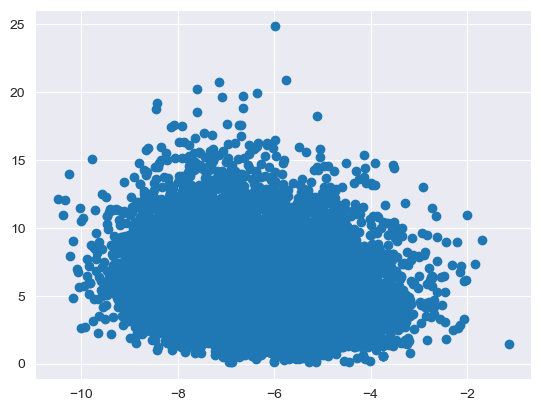

In [37]:
all_data_positive = all_data[all_data["Total_E"] >= 0]
plt.scatter(all_data_positive["r_i_docking_score"], all_data_positive["Total_E"])

In [38]:
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

In [39]:
def identify_pareto(scores):
    population_size = scores.shape[0]
    pareto_front = np.ones(population_size, dtype=bool)
    for i in range(population_size):
        for j in range(population_size):
            if all(scores[j] <= scores[i]) and any(scores[j] < scores[i]):
                pareto_front[i] = 0
                break
    return np.where(pareto_front == 1)[0]


def find_pareto_ranks(scores, max_ranks=100):
    ranks = []
    remaining_scores = scores.copy()
    remaining_indices = np.arange(scores.shape[0])
    for _ in range(max_ranks):
        pareto_indices = identify_pareto(remaining_scores)
        ranks.append(remaining_indices[pareto_indices])
        remaining_scores = np.delete(remaining_scores, pareto_indices, axis=0)
        remaining_indices = np.delete(remaining_indices, pareto_indices)
        if remaining_scores.shape[0] == 0:
            break
    return ranks



In [40]:
data = all_data_positive

In [41]:
# Extract the scores for the entire dataset
scores = data[["r_i_docking_score", "Total_E"]].values

# Find the ranks of Pareto fronts until all points are classified or a max limit is reached
pareto_ranks_indices = find_pareto_ranks(
    scores, max_ranks=20
)  # Adjust max_ranks as needed

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_73901/1624393553.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, num_ranks - 1, num_ranks))


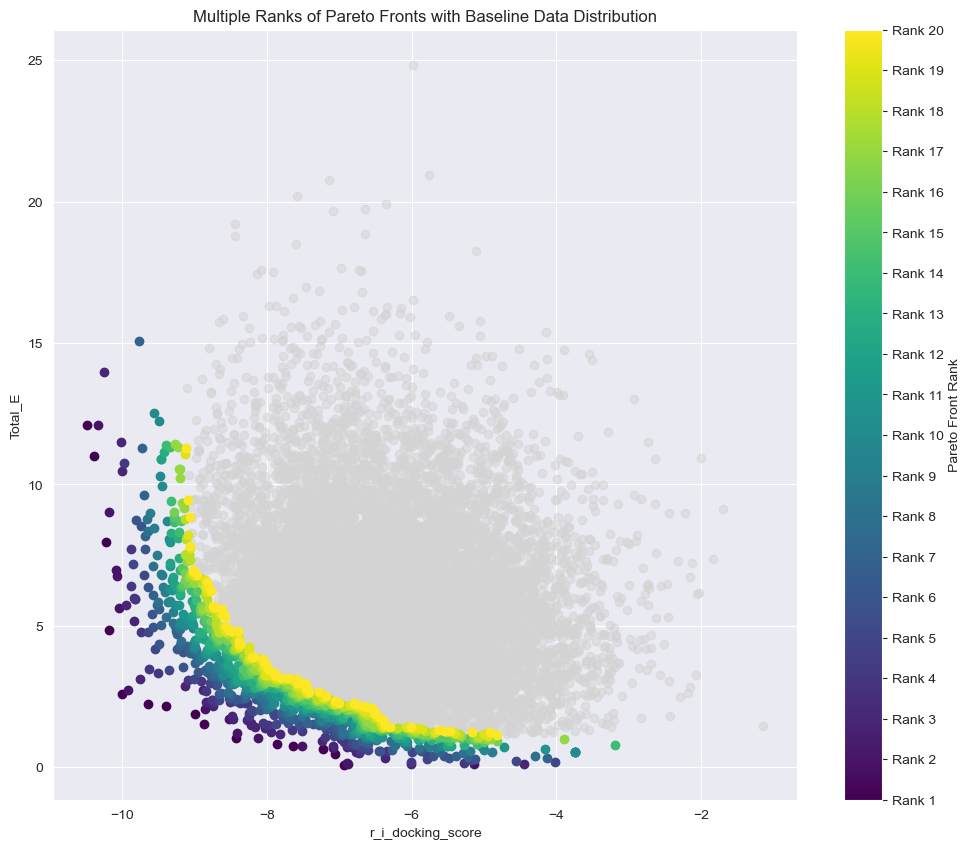

In [42]:
# Determine the actual number of ranks found
num_ranks = len(pareto_ranks_indices)

# Plot the baseline data distribution
plt.figure(figsize=(12, 10))
plt.scatter(
    data["r_i_docking_score"],
    data["Total_E"],
    color="lightgrey",
    label="Baseline Data",
    alpha=0.5,
)

# Generate colors for each rank dynamically using a colormap
colormap = viridis
norm = Normalize(vmin=0, vmax=num_ranks - 1)

for i, indices in enumerate(pareto_ranks_indices):
    rank_data = data.iloc[indices]
    plt.scatter(
        rank_data["r_i_docking_score"],
        rank_data["Total_E"],
        color=colormap(norm(i)),
        label=f"Rank {i+1}",
    )

plt.title("Multiple Ranks of Pareto Fronts with Baseline Data Distribution")
plt.xlabel("r_i_docking_score")
plt.ylabel("Total_E")

# Create a custom legend
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(0, num_ranks - 1, num_ranks))
cbar.ax.set_yticklabels([f"Rank {i+1}" for i in range(num_ranks)])
cbar.set_label("Pareto Front Rank")

plt.grid(True)
plt.show()

In [43]:
# Count the number of Pareto points per rank and the total
num_points_per_rank = [len(indices) for indices in pareto_ranks_indices]
total_points = sum(num_points_per_rank)

# Print the counts
print("Number of Pareto points per rank:")
for rank, count in enumerate(num_points_per_rank, start=1):
    print(f"Rank {rank}: {count} points")

print(f"\nTotal Pareto points across all ranks: {total_points}")

Number of Pareto points per rank:
Rank 1: 15 points
Rank 2: 15 points
Rank 3: 28 points
Rank 4: 33 points
Rank 5: 30 points
Rank 6: 40 points
Rank 7: 46 points
Rank 8: 44 points
Rank 9: 43 points
Rank 10: 53 points
Rank 11: 49 points
Rank 12: 47 points
Rank 13: 54 points
Rank 14: 64 points
Rank 15: 64 points
Rank 16: 56 points
Rank 17: 68 points
Rank 18: 74 points
Rank 19: 64 points
Rank 20: 66 points

Total Pareto points across all ranks: 953


In [44]:
all_pareto_ranks_indices = np.concatenate(pareto_ranks_indices)
display(data.iloc[all_pareto_ranks_indices])

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened
1,C39794003_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x15ec16ea0>,0,P2Y12_chembl19_set_decoy_sc.smi,6297,53161,0,S-OPLS,38.0159,1,C39794003_Isomer1-1,P2Y12,6295,8,-10.48680,-0.34956,-1.08616,-2.38272,-10.4868,-3.40285,-0.666682,-0,-2.88739,-53.892,-8.25561,0.423472,-0.0204131,-95.4206,-62.1476,5.12474,16,292,0,12.098180,9.878964,NaN,4.0,0,205,0.000000,0.000087
2,C20906690_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x15ec16f80>,0,P2Y12_chembl19_set_decoy_sc.smi,6679,53161,0,S-OPLS,27.7373,1,C20906690_Isomer1-1,P2Y12,6677,10,-10.38470,-0.33499,-1.05233,-2.34206,-10.3847,-3.3933,-1.19354,-0,-1.5536,-43.2751,-17.6723,0.826727,-0.25638,-100.397,-60.9474,8.29938,60,194,0,10.987322,8.922633,NaN,5.0,0,205,0.000000,0.000175
5,C40435144_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x15ec171b0>,0,P2Y12_chembl19_set_decoy_sc.smi,10756,53161,0,S-OPLS,52.7382,1,C40435144_Isomer1-1,P2Y12,10754,6,-10.22860,-0.292247,-0.95596,-2.24542,-10.2286,-4.64221,-0.517898,-0,-1.52622,-56.7634,-7.81131,0.509474,-0.0419297,-101.348,-64.5747,11.4477,36,386,0,7.945418,6.210284,NaN,1.0,0,205,0.000000,0.000437
6,C39154837_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x15ec174c0>,0,P2Y12_chembl19_set_decoy_sc.smi,6695,53161,0,S-OPLS,52.4899,1,C39154837_Isomer1-1,P2Y12,6693,8,-10.18100,-0.32842,-1.03169,-2.29613,-10.181,-3.63335,-0.334669,-0,-2.78719,-53.7865,-8.48675,0.557476,-0.0209644,-106.471,-62.2732,3.53905,114,103,0,4.856688,4.316201,5.567128,3.0,0,205,0.000000,0.000525
13,C32893514_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x15ec17370>,0,P2Y12_chembl19_set_decoy_sc.smi,1137,53161,0,S-OPLS,45.1938,1,C32893514_Isomer1-1,P2Y12,1136,6,-9.99635,-0.322463,-1.01298,-2.25448,-9.99635,-4.19212,-0.32,-0,-2.9381,-48.3684,-4.37542,0.538654,-0.010053,-81.2159,-52.7438,5.99337,4,285,0,2.588029,2.125389,3.159866,2.0,0,205,0.000000,0.001137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8502,C19942006_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a43bfdf0>,0,P2Y12_chembl19_set_decoy_sc.smi,10956,53161,0,S-OPLS,41.3934,1,C19942006_Isomer1-1,P2Y12,10954,5,-5.54524,-0.264059,-0.728519,-1.37105,-5.54524,-1.92838,-0.26623,-0,-1.4697,-29.7524,-6.46743,0.644642,-0.0678347,-48.1968,-36.2198,0.880113,2,205,0,1.279078,0.990573,1.604985,3.0,204,205,0.995122,0.743702
8700,C77055188_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a4f41460>,0,P2Y12_chembl19_set_decoy_sc.smi,8519,53161,0,S-OPLS,32.1866,1,C77055188_Isomer1-1,P2Y12,8517,5,-5.47177,-0.26056,-0.718866,-1.35288,-5.47177,-1.24929,-0.198117,-0,-1.86665,-29.0522,-5.61035,0.213754,-0.0773022,-51.973,-34.6626,0.616817,4,171,0,1.271819,1.075080,1.492584,4.0,205,205,1.000000,0.761022
9485,C14540586_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a6a9aff0>,0,P2Y12_chembl19_set_decoy_sc.smi,9667,53161,0,S-OPLS,35.6917,1,C14540586_Isomer1-1,P2Y12,9665,4,-5.16499,-0.198654,-0.58851,-1.21298,-5.16499,-1.62199,-0.2,-0,-1.07568,-30.0131,-7.82144,0.556837,-0.150292,-56.0107,-37.8345,2.52972,21,69,0,1.245378,1.000663,1.518860,1.0,205,205,1.000000,0.829689
10009,C50616309_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a7ca5700>,0,P2Y12_chembl19_set_decoy_sc.smi,6551,53161,0,S-OPLS,50.1884,1,C50616309_Isomer1-1,P2Y12,6549,4,-4.91016,

In [45]:
pareto_front_df = data.iloc[all_pareto_ranks_indices]

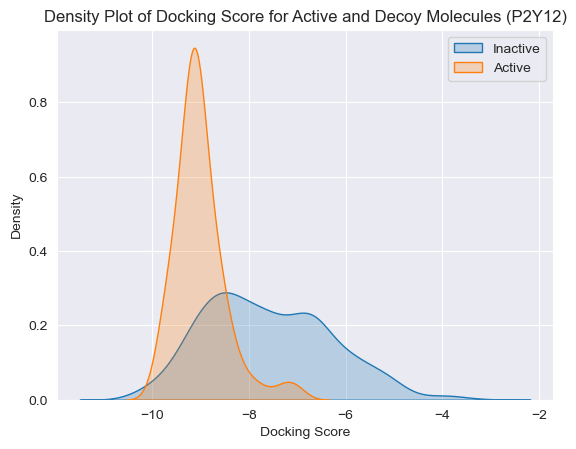

In [46]:
plot_density(pareto_front_df, title_suffix)

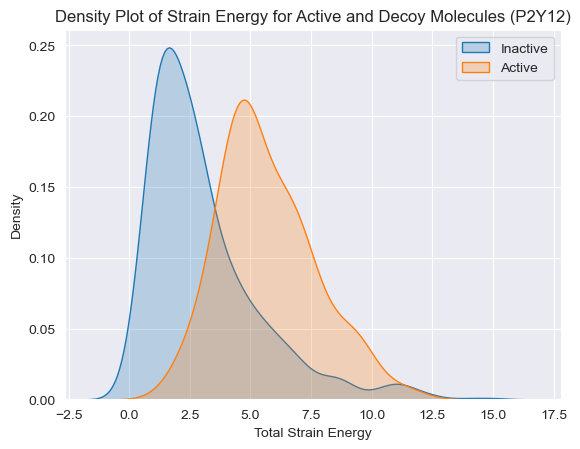

In [47]:
plot_density_strain(pareto_front_df, title_suffix)

In [48]:
pareto_front_df = calculate_enrichment_parameters(pareto_front_df)

In [49]:
def plot_enrichment_curve_classifier(df, title_suffix):
    """
    Plots the enrichment curve for a dataframe, including the performance of a random classifier.

    Parameters:
    df (pandas.DataFrame): The dataframe to plot the enrichment curve for.
    title_suffix (str): The suffix to add to the title of the plot.

    Returns:
    None
    """
    # Calculate the Enrichment AUC
    enrichment_auc = auc(df["Percentage_Screened"], df["Fraction_Actives"])

    # Calculate the enrichment at the closest value to 1%
    # Subtract 0.01 (1%) from the 'Percentage_Screened' column and find the absolute value
    # (df['Percentage_Screened'] - 0.01).abs()
    # Sort the resulting series and take the first index (smallest difference)
    # (df['Percentage_Screened'] - 0.01).abs().argsort()[:1]
    # Use the index to get the row from the dataframe
    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]
    # df["Some_Column"].values[0] gets the value of the first row of "Some_Column"
    # It would return a pd.Series without: .values[0]
    enrichment_at_one_percent = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
    )

    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    # df["Some_Column"].values[0] gets the value of the first row of "Some_Column"
    # It would return a pd.Series without: .values[0]
    enrichment_at_five_percent = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]
    )

    # Plot the enrichment curve
    plt.plot(
        df["Percentage_Screened"] * 100,
        df["Fraction_Actives"] * 100,
        label="Enrichment AUC = {:.2f}\n(EF1% = {:.1f}%)\n(EF5% = {:.0f}%)".format(
            enrichment_auc,
            enrichment_at_one_percent * 100,
            enrichment_at_five_percent * 100,
        ),
    )

    #   # Plot the enrichment at 1%
    #   plt.scatter(
    #   1,
    #   enrichment_at_one_percent * 100,
    #   s=0,
    #   color='black',
    #   label="Enrichment (%) at 1% = {:.2f}".format(enrichment_at_one_percent*100),
    # )

    # Calculate and plot the performance of a random classifier
    overall_fraction_actives = df["Fraction_Actives"].iloc[
        -1
    ]  # Assuming the last point represents the overall fraction
    plt.plot(
        [0, 100],
        [0, overall_fraction_actives * 100],
        label="Random Classifier",
        linestyle="--",
        color="grey",
    )

    # Add axis labels and title
    plt.xlabel("Compounds Screened (%)")
    plt.ylabel("Percent of Identified Actives (%)")
    plt.title(f"Enrichment Curve ({title_suffix})")

    plt.legend()
    plt.show()


In [50]:
threshold4 = all_data[all_data["Total_E"] <= 4]
threshold4 = calculate_enrichment_parameters(threshold4)

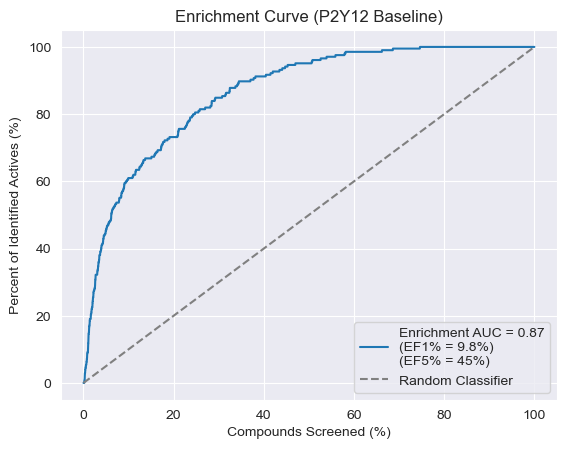

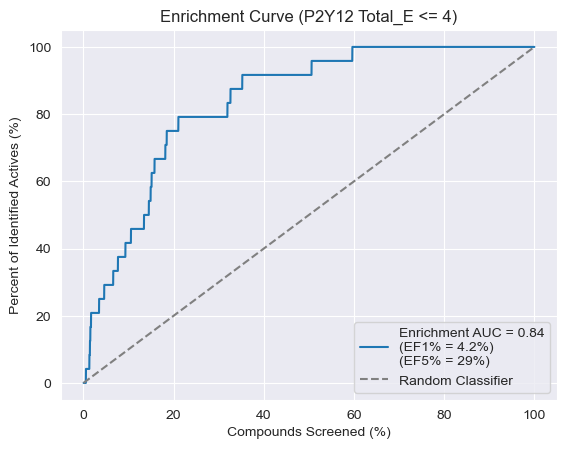

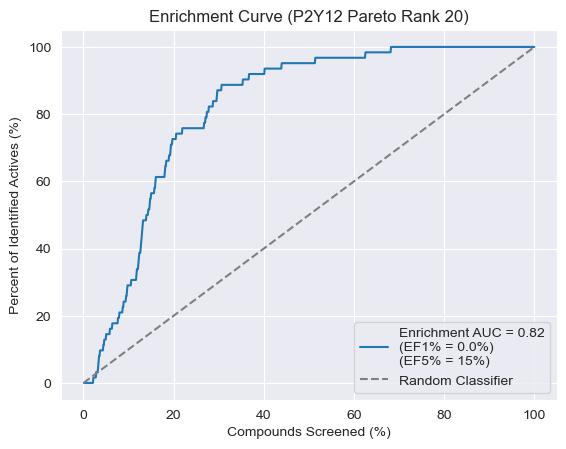

In [51]:
title_suffix_baseline = title_suffix + " Baseline"
title_suffix_threshold = title_suffix + " Total_E <= 4"
title_suffix_pareto = title_suffix + " Pareto Rank 20"
plot_enrichment_curve_classifier(all_data, title_suffix_baseline)
plot_enrichment_curve_classifier(threshold4, title_suffix_threshold)
plot_enrichment_curve_classifier(pareto_front_df, title_suffix_pareto)